### Network Intrusion Detection with Logistic Regression
###### Data Science for Cyber Security - Step by Step Approach

#### Environment Setup

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

### Generate Realistic Network Traffic Data

In [65]:
# Create synthetic network traffic data that mimics real scenarios
np.random.seed(42)  # For reproducible results

def generate_network_data(n_samples=1000):
    """
    Generate synthetic network traffic data with realistic patterns
    """
    data = []
    
    for i in range(n_samples):
        # Randomly decide if this is normal (0) or suspicious (1) traffic
        is_suspicious = np.random.choice([0, 1], p=[0.85, 0.15])  # 15% suspicious
        
        if is_suspicious == 0:  # Normal traffic
            packet_count = np.random.normal(50, 15)  # Moderate packet count
            duration = np.random.exponential(30)      # Short duration
            bytes_sent = np.random.normal(1500, 500)  # Normal data size
            connection_freq = np.random.poisson(5)    # Low frequency
            
        else:  # Suspicious traffic
            # Suspicious patterns: either very high or very low values
            attack_type = np.random.choice(['ddos', 'scan', 'exfiltration'])
            
            if attack_type == 'ddos':
                packet_count = np.random.normal(200, 50)   # High packet count
                duration = np.random.exponential(5)        # Very short duration  
                bytes_sent = np.random.normal(800, 200)    # Small packets
                connection_freq = np.random.poisson(20)    # High frequency
                
            elif attack_type == 'scan':
                packet_count = np.random.normal(10, 5)     # Very few packets
                duration = np.random.exponential(2)        # Very short duration
                bytes_sent = np.random.normal(200, 50)     # Tiny packets
                connection_freq = np.random.poisson(15)    # High frequency
                
            else:  # exfiltration
                packet_count = np.random.normal(150, 30)   # High packet count
                duration = np.random.exponential(120)      # Long duration
                bytes_sent = np.random.normal(5000, 1000)  # Large data transfer
                connection_freq = np.random.poisson(2)     # Low frequency
        
        # Ensure positive values
        packet_count = max(1, packet_count)
        duration = max(0.1, duration)
        bytes_sent = max(10, bytes_sent)
        connection_freq = max(1, connection_freq)
        
        data.append({
            'packet_count': int(packet_count),
            'duration_seconds': round(duration, 2),
            'bytes_transferred': int(bytes_sent),
            'connection_frequency': int(connection_freq),
            'is_suspicious': is_suspicious
        })
    
    return pd.DataFrame(data)

# Generate our dataset
df = generate_network_data(2000)
print("Dataset created!")
print(f"Total samples: {len(df)}")
print(f"Normal traffic: {len(df[df['is_suspicious'] == 0])} ({len(df[df['is_suspicious'] == 0])/len(df)*100:.1f}%)")
print(f"Suspicious traffic: {len(df[df['is_suspicious'] == 1])} ({len(df[df['is_suspicious'] == 1])/len(df)*100:.1f}%)")
print("\nFirst few samples:")
df.head()

Dataset created!
Total samples: 2000
Normal traffic: 1685 (84.2%)
Suspicious traffic: 315 (15.8%)

First few samples:


,packet_count,duration_seconds,bytes_transferred,connection_frequency,is_suspicious
0,33,5.09,1659,4,0
1,7,0.41,173,13,1
2,62,4.51,738,5,0
3,51,5.61,1242,5,0
4,34,20.51,1419,3,0


### Exploratory Data Analysis

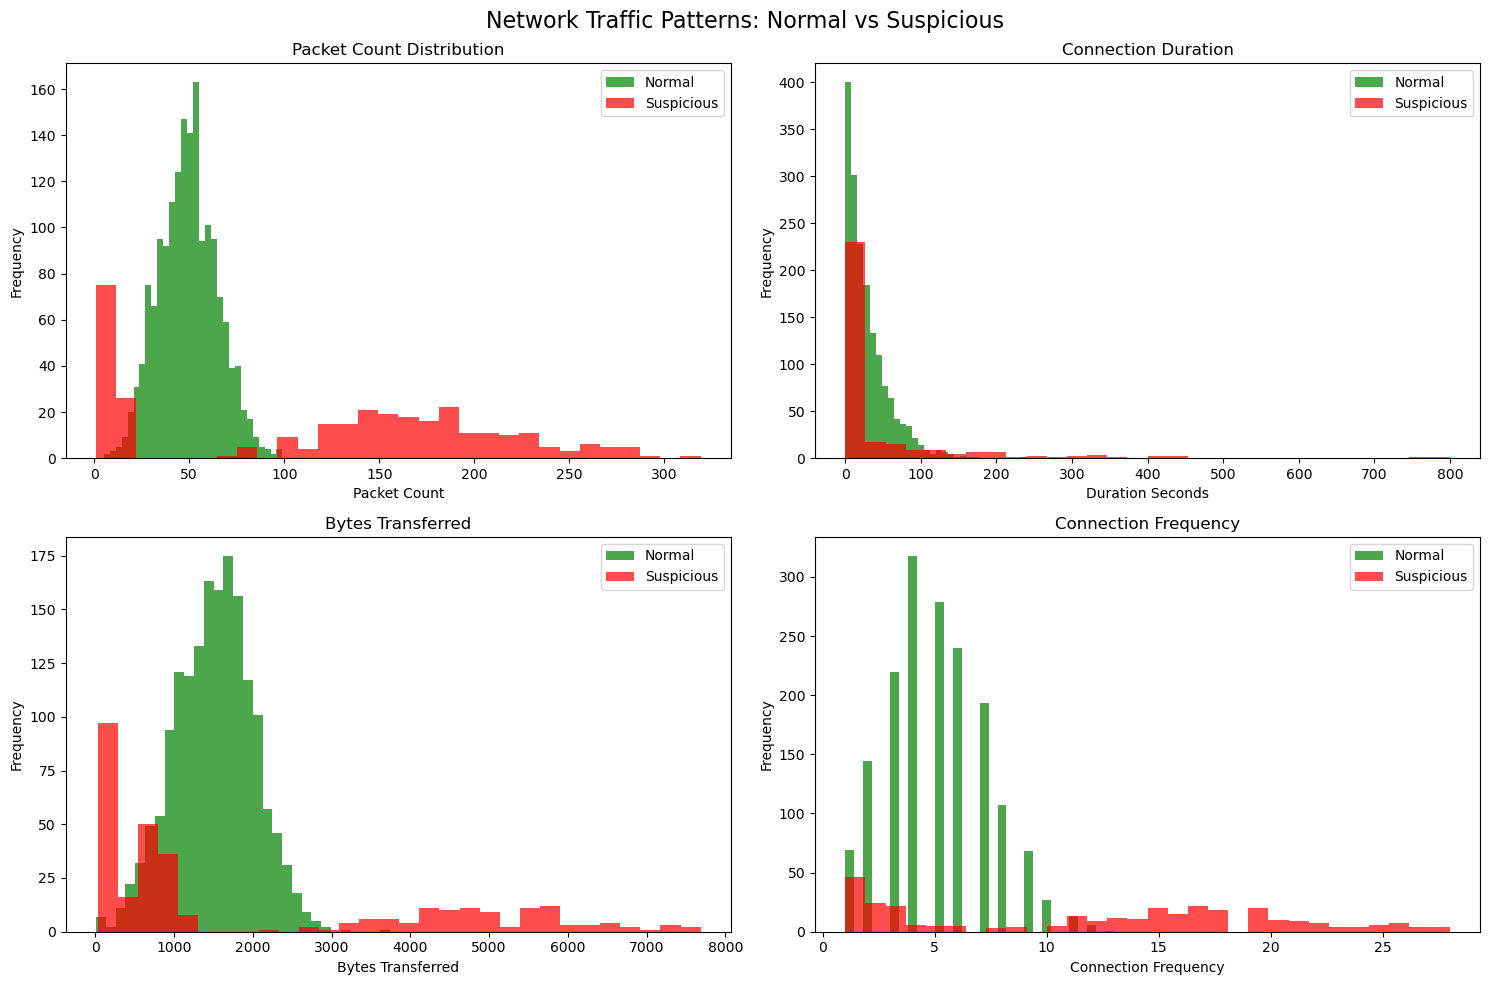


Summary Statistics by Traffic Type:
              packet_count                                                 \
                     count    mean    std  min   25%    50%    75%    max   
is_suspicious                                                               
0                   1685.0   49.38  15.18  5.0  39.0   49.0   60.0   99.0   
1                    315.0  122.28  87.77  1.0  12.0  141.0  188.0  319.0   

              duration_seconds         ... bytes_transferred          \
                         count   mean  ...               75%     max   
is_suspicious                          ...                             
0                       1685.0  29.31  ...            1853.0  3739.0   
1                        315.0  44.72  ...            4277.5  7687.0   

              connection_frequency                                           
                             count   mean   std  min  25%   50%   75%   max  
is_suspicious                                               

In [68]:
# Examine the data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Network Traffic Patterns: Normal vs Suspicious', fontsize=16)

features = ['packet_count', 'duration_seconds', 'bytes_transferred', 'connection_frequency']
titles = ['Packet Count Distribution', 'Connection Duration', 'Bytes Transferred', 'Connection Frequency']

for i, (feature, title) in enumerate(zip(features, titles)):
    row, col = i // 2, i % 2
    
    # Create histograms for normal and suspicious traffic
    normal_data = df[df['is_suspicious'] == 0][feature]
    suspicious_data = df[df['is_suspicious'] == 1][feature]
    
    axes[row, col].hist(normal_data, alpha=0.7, label='Normal', bins=30, color='green')
    axes[row, col].hist(suspicious_data, alpha=0.7, label='Suspicious', bins=30, color='red')
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel(feature.replace('_', ' ').title())
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nSummary Statistics by Traffic Type:")
print(df.groupby('is_suspicious')[features].describe().round(2))

### Data Preprocessing

In [71]:
# Separate features and target variable
X = df[['packet_count', 'duration_seconds', 'bytes_transferred', 'connection_frequency']]
y = df['is_suspicious']

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures have been standardized!")
print("Training features mean:", np.round(X_train_scaled.mean(axis=0), 3))
print("Training features std:", np.round(X_train_scaled.std(axis=0), 3))

Feature matrix shape: (2000, 4)
Target vector shape: (2000,)

Training set: 1400 samples
Testing set: 600 samples

Features have been standardized!
Training features mean: [-0.  0. -0.  0.]
Training features std: [1. 1. 1. 1.]


### Build and Train Logistic Regression Model

In [74]:
# Create and train logistic regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

print("Logistic Regression Model Trained!")

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]  # Probability of being suspicious

print(f"Predictions made on {len(X_test)} test samples")

# Display model coefficients (feature importance)
feature_names = ['packet_count', 'duration_seconds', 'bytes_transferred', 'connection_frequency']
coefficients = lr_model.coef_[0]

print("\nModel Interpretability - Feature Coefficients:")
for feature, coef in zip(feature_names, coefficients):
    direction = "increases" if coef > 0 else "decreases"
    print(f"  {feature}: {coef:.3f} - {direction} suspicion probability")

Logistic Regression Model Trained!
Predictions made on 600 test samples

Model Interpretability - Feature Coefficients:
  packet_count: 1.461 - increases suspicion probability
  duration_seconds: 0.222 - increases suspicion probability
  bytes_transferred: 1.266 - increases suspicion probability
  connection_frequency: 3.375 - increases suspicion probability


### Evaluate Model Performance

Logistic Regression Performance:
  Accuracy: 0.947 - Overall correct predictions
  Precision: 0.869 - Of flagged connections, how many were actually suspicious
  Recall: 0.777 - Of all suspicious connections, how many were caught
  F1-Score: 0.820 - Balance between precision and recall
  AUC-ROC: 0.968 - Model's ability to distinguish classes

Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       506
  Suspicious       0.87      0.78      0.82        94

    accuracy                           0.95       600
   macro avg       0.91      0.88      0.89       600
weighted avg       0.95      0.95      0.95       600



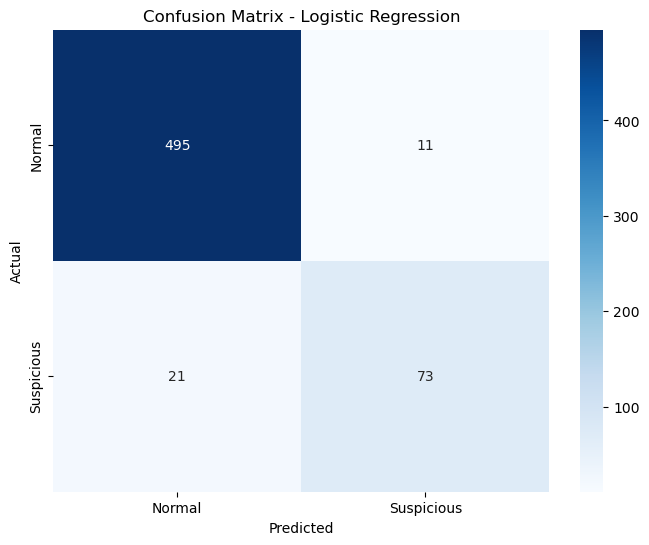

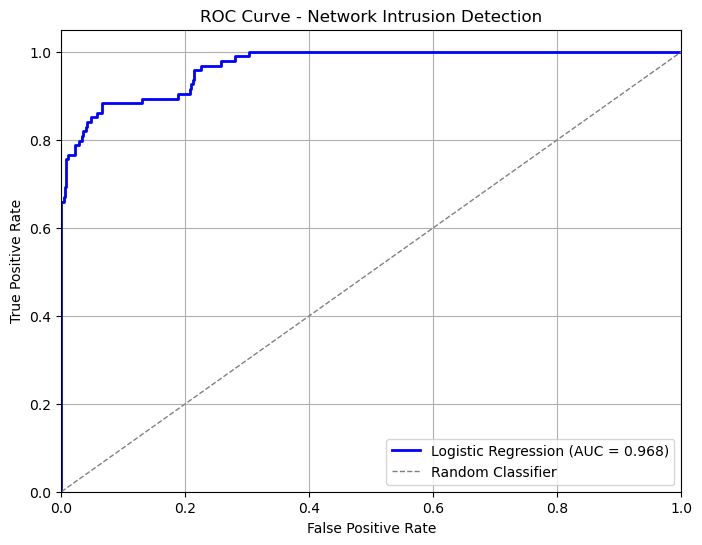

In [77]:
# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
auc_score = roc_auc_score(y_test, y_pred_proba_lr)

print("Logistic Regression Performance:")
print(f"  Accuracy: {accuracy:.3f} - Overall correct predictions")
print(f"  Precision: {precision:.3f} - Of flagged connections, how many were actually suspicious")
print(f"  Recall: {recall:.3f} - Of all suspicious connections, how many were caught")
print(f"  F1-Score: {f1:.3f} - Balance between precision and recall")
print(f"  AUC-ROC: {auc_score:.3f} - Model's ability to distinguish classes")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Suspicious']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Suspicious'], 
            yticklabels=['Normal', 'Suspicious'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Network Intrusion Detection')
plt.legend()
plt.grid(True)
plt.show()

### Real-World Application Example

In [84]:
# Simulate real-time detection on new network connections
print("Simulating Real-Time Network Monitoring System")
print("=" * 55)

# Generate new "live" network connections for monitoring
new_connections = generate_network_data(15)
X_new = new_connections[['packet_count', 'duration_seconds', 'bytes_transferred', 'connection_frequency']]
X_new_scaled = scaler.transform(X_new)

# Make predictions using our trained logistic regression model
predictions = lr_model.predict(X_new_scaled)
probabilities = lr_model.predict_proba(X_new_scaled)[:, 1]

# Create a monitoring dashboard simulation
print("🔍 Network Security Monitoring Dashboard")
print("-" * 55)

suspicious_count = 0
normal_count = 0

for i, (idx, connection) in enumerate(new_connections.iterrows()):
    # Determine alert status
    is_flagged = predictions[i] == 1
    confidence = probabilities[i] if is_flagged else (1 - probabilities[i])
    
    # Classify by risk level
    if is_flagged:
        if confidence > 0.8:
            risk_level = "🔴 HIGH RISK"
        elif confidence > 0.6:
            risk_level = "🟡 MEDIUM RISK"
        else:
            risk_level = "🟠 LOW RISK"
        suspicious_count += 1
        status_emoji = "🚨"
    else:
        risk_level = "✅ NORMAL"
        normal_count += 1
        status_emoji = "✅"
    
    # Display connection details
    print(f"{status_emoji} Connection {i+1:2d}: {risk_level} (Confidence: {confidence:.2f})")
    print(f"   📊 Packets: {int(connection['packet_count']):3d} | Duration: {connection['duration_seconds']:6.2f}s")
    print(f"   💾 Bytes: {int(connection['bytes_transferred']):5d} | Frequency: {int(connection['connection_frequency']):2d}")
    
    # Show what features contributed to the decision
    feature_values = X_new_scaled[i]
    feature_names = ['packet_count', 'duration_seconds', 'bytes_transferred', 'connection_frequency']
    coefficients = lr_model.coef_[0]
    
    # Calculate feature contributions
    contributions = feature_values * coefficients
    
    if is_flagged:
        # Show top contributing features for suspicious classification
        contrib_df = pd.DataFrame({
            'feature': feature_names,
            'contribution': contributions
        }).sort_values('contribution', key=abs, ascending=False)
        
        print(f"   🎯 Key Risk Factors:")
        for _, row in contrib_df.head(2).iterrows():
            direction = "↑" if row['contribution'] > 0 else "↓"
            print(f"      {direction} {row['feature'].replace('_', ' ').title()}: {row['contribution']:.3f}")
    
    # Show actual vs predicted for learning purposes
    actual_status = "Suspicious" if connection['is_suspicious'] == 1 else "Normal"
    correct = "✓" if (is_flagged and connection['is_suspicious'] == 1) or (not is_flagged and connection['is_suspicious'] == 0) else "✗"
    print(f"   📋 Actual: {actual_status} | Prediction: {correct}")
    print("-" * 55)

# Summary statistics
print(f"\n📈 Monitoring Session Summary:")
print(f"   Total Connections Analyzed: {len(new_connections)}")
print(f"   🚨 Flagged as Suspicious: {suspicious_count}")
print(f"   ✅ Classified as Normal: {normal_count}")
print(f"   📊 Suspicious Traffic Rate: {suspicious_count/len(new_connections)*100:.1f}%")

# Calculate accuracy for this batch
correct_predictions = sum(1 for i in range(len(predictions)) if 
                         (predictions[i] == 1 and new_connections.iloc[i]['is_suspicious'] == 1) or
                         (predictions[i] == 0 and new_connections.iloc[i]['is_suspicious'] == 0))
accuracy = correct_predictions / len(predictions)
print(f"   🎯 Detection Accuracy: {accuracy:.1%}")

# Alert prioritization for security team
print(f"\n🔔 Security Team Alerts:")
high_risk_connections = [(i, prob) for i, prob in enumerate(probabilities) if predictions[i] == 1 and prob > 0.8]

if high_risk_connections:
    print("   Priority investigations required for:")
    for conn_id, prob in high_risk_connections:
        print(f"   🚨 Connection {conn_id + 1} (Risk Score: {prob:.3f})")
else:
    print("   ℹ️  No high-risk connections detected in this monitoring cycle.")

print("\n" + "=" * 55)
print("🛡️  Network monitoring cycle complete. Standing by for next batch...")

Simulating Real-Time Network Monitoring System
🔍 Network Security Monitoring Dashboard
-------------------------------------------------------
🚨 Connection  1: 🟡 MEDIUM RISK (Confidence: 0.69)
   📊 Packets:   5 | Duration:   0.10s
   💾 Bytes:   337 | Frequency: 16
   🎯 Key Risk Factors:
      ↑ Connection Frequency: 7.250
      ↓ Packet Count: -1.757
   📋 Actual: Suspicious | Prediction: ✓
-------------------------------------------------------
✅ Connection  2: ✅ NORMAL (Confidence: 1.00)
   📊 Packets:  74 | Duration:   3.21s
   💾 Bytes:  1064 | Frequency:  2
   📋 Actual: Normal | Prediction: ✓
-------------------------------------------------------
✅ Connection  3: ✅ NORMAL (Confidence: 0.96)
   📊 Packets:  57 | Duration:  25.67s
   💾 Bytes:  2138 | Frequency:  5
   📋 Actual: Normal | Prediction: ✓
-------------------------------------------------------
✅ Connection  4: ✅ NORMAL (Confidence: 0.92)
   📊 Packets:  59 | Duration:  28.20s
   💾 Bytes:  1566 | Frequency:  7
   📋 Actual: Nor